In [49]:
# %load phrase_identification.py
from collections import defaultdict
from music21 import *

from qubo_form import max_num_measures


def get_pitch_int(file):
    pitch_int = defaultdict(list)
    for i, part in enumerate(file.parts):
        for p1,p2 in zip(part.pitches, part.pitches[1:]):
            intvl = interval.Interval(p1,p2)
            pitch_int[i].append(abs(intvl.chromatic.semitones)+1)
    return pitch_int

def get_ioi(file):
    ioi = defaultdict(list)
    for i, part in enumerate(file.parts):
        notes = part.flat.getElementsByClass(['Note', 'Chord'])
        for n1, n2 in zip(notes, notes[1:]):
            ioi[i].append(n2.offset - n1.offset)
    return ioi

def get_rests(file):
    rests = defaultdict(list)
    for i, part in enumerate(file.parts):
        notes = part.flat.getElementsByClass(['Note', 'Chord'])
        for n1, n2 in zip(notes, notes[1:]):
            rests[i].append((n2.offset) - (n1.offset + n1.duration.quarterLength)+1)
    return rests

def get_doc(no_parts, intervals):
    rdict = defaultdict(lambda: [0])
    for i in range(no_parts):
        rdict[i] += [abs(int2-int1)/(int1+int2) for int1,int2 in zip(intervals[i],intervals[i][1:])]
    return rdict

def get_strength(no_parts,intervals,doc):
    sdict = defaultdict(list)
    for i in range(no_parts):
        slist = [intervals[i][j+1]*(doc[i][j]+doc[i][j+1]) for j in range(len(intervals[i])-1)]
        s = sum(slist)
        if s!=0:
            slist = [r/s for r in slist]
        sdict[i] = slist
    return sdict

def get_measures(file, i):
    measures = []
    import math
    for n in file.parts[i].flat.getElementsByClass(['Note', 'Chord']):
        measures.append(math.ceil(n.offset / 4))
    return measures

def find_maxima(a,threshold):
    mlist = []
    for i in range(1,len(a)-1):
        if a[i]>a[i+1] and a[i-1]<a[i] and a[i]>threshold :
            mlist.append(i)
    return mlist

def find_maxima_measures(measures,mlist):
    meas_list = [0]
    if mlist!=[]:
        meas_list += [measures[m] for m in mlist]
    return meas_list


def get_phrase_list(file, p):
    no_parts = len(file.parts)

    pitch_int = get_pitch_int(file)
    rpitch = get_doc(no_parts, pitch_int)
    print(pitch_int[0])
    
    ioi = get_ioi(file)
    rioi = get_doc(no_parts, ioi)
    print(ioi[0])

    rests = get_rests(file)
    rrests = get_doc(no_parts, rests)

    spitch = get_strength(no_parts, pitch_int, rpitch)
    sioi = get_strength(no_parts, ioi, rioi)
    srests = get_strength(no_parts,rests,rrests)

    lbsp = [0] * no_parts
    max_measures = defaultdict(int)
    for i in range(no_parts):
        lbsp[i] = [0.25 * pitch + 0.5 * ioi + 0.25*rest for pitch, ioi,rest in zip(spitch[i], sioi[i],srests[i])]
        mlist = find_maxima(lbsp[i], p)
        measures = get_measures(file, i)
        max_measures[i] = find_maxima_measures(measures, mlist)
        max_measures[i].append(max_num_measures(file))

    print(len(max_measures))
    return lbsp


In [50]:
def get_phrase_list1(file, p):
    no_parts = len(file.parts)

    pitch_int = get_pitch_int(file)
    rpitch = get_doc(no_parts, pitch_int)
    print(pitch_int)
    ioi = get_ioi(file)
    rioi = get_doc(no_parts, ioi)
    print(ioi[0])

    rests = get_rests(file)

    spitch = get_strength(no_parts, pitch_int, rpitch)
    sioi = get_strength(no_parts, ioi, rioi)


    lbsp = [0] * no_parts
    max_measures = defaultdict(int)
    for i in range(no_parts):
        lbsp[i] = [0.25 * pitch + 0.75 * ioi for pitch, ioi in zip(spitch[i], sioi[i])]
        mlist = find_maxima(lbsp[i], p)
        measures = get_measures(file, i)
        max_measures[i] = find_maxima_measures(measures, mlist)
        max_measures[i].append(max_num_measures(file))
    print(len(max_measures))
    return lbsp

In [57]:
p1 = 1
p2 = 1

file = converter.parse('symphony.mid')
file1 = file.measures(1,40)
lbsp1 = get_phrase_list1(file1, p1)
lbsp2 = get_phrase_list(file1, p2)

print(lbsp1)

defaultdict(<class 'list'>, {0: [6, 6, 6, 4, 4, 2, 4, 1, 8, 9, 4, 1, 1, 4, 1, 8, 1], 1: [6, 1, 6, 4, 4, 2, 4, 7, 7, 2, 9, 2, 1, 1, 4, 1, 1, 1, 1, 3, 5, 5, 5, 5, 6, 4, 3, 4, 5, 4], 2: [1, 1, 5, 3, 1, 1, 4, 1, 8, 5, 4, 4, 4, 6, 5, 5, 2, 7, 2, 4, 7, 1, 1, 4, 1, 10, 1, 1, 3, 8, 4, 2, 4, 2, 4], 3: [1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 17, 2, 2, 1, 1, 4, 1, 27, 5, 5, 5, 5, 12, 11, 3, 9], 4: [1, 1, 1, 17, 13, 5, 13, 14, 1, 1, 4, 1, 11, 13, 13, 13, 13, 13, 13, 13, 2, 4, 4, 4], 5: [13, 1, 13, 13, 13, 18, 13, 1, 13, 18, 13], 6: [1, 1, 6, 1, 6], 7: [1, 1, 5, 3, 1, 1, 4, 1, 14, 1, 1, 4, 1, 6, 1, 1, 4, 1, 6, 1, 3, 3, 2, 6, 1, 3, 3, 2, 6, 1, 3, 3, 10, 11, 17, 8, 25, 17, 10, 7, 1, 1, 4, 1, 4, 1, 1, 4, 1, 1, 3, 6, 1, 1, 4, 1, 1, 3, 5, 6, 1, 1, 2, 1, 1, 4, 1, 3, 1, 1, 4, 1, 2, 1, 4, 1, 2, 1, 4, 1, 3, 1, 4], 8: [1, 1, 5, 3, 1, 1, 4, 1, 6, 1, 1, 5, 1, 1, 1, 5, 1, 1, 6, 1, 6, 1, 1, 5, 1, 3, 3, 1, 5, 1, 3, 3, 8, 1, 8, 9, 9, 8, 5, 11, 7, 11, 10, 17, 14, 1, 1, 4, 1, 4, 1, 1, 4, 1, 2, 3, 1, 1, 4, 1, 2

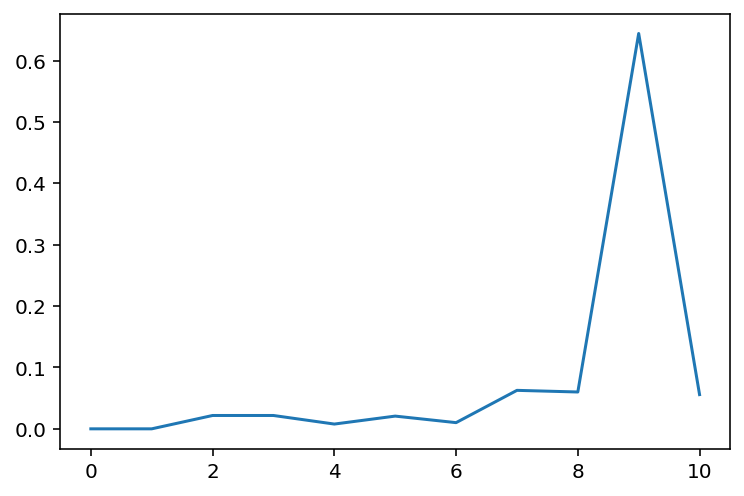

In [58]:
import matplotlib.pyplot as plt
plt.plot(lbsp1[0])

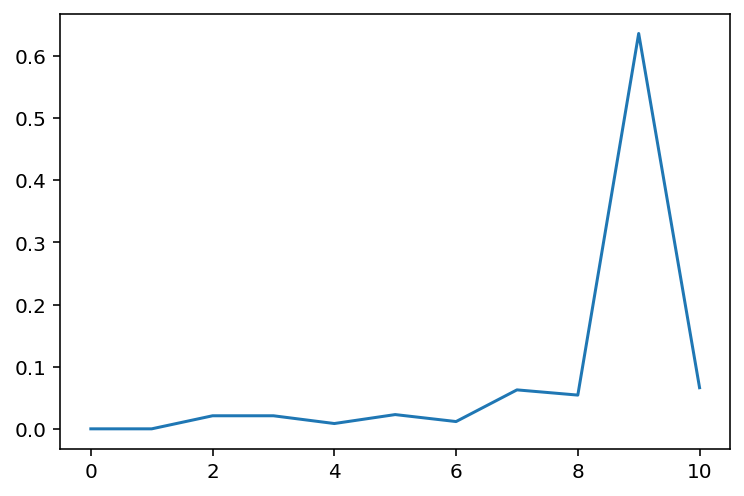

In [59]:
import matplotlib.pyplot as plt
plt.plot(lbsp2[0])